# либы

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os import path
from imageio.v2 import imread
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torch.optim import *
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F


from lion_pytorch import Lion
import math
import time
import numpy as np
from PIL import Image
import cv2
import numpy as np
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib import font_manager, rc
from IPython import display
import random
import glob
import os
from os import listdir
from os.path import isfile, join
import warnings
import sys
from tqdm import tqdm
import pickle
import gc
import random
import urllib.request

warnings.filterwarnings("ignore")

print("Version of Torch : {0}".format(torch.__version__))
print("Version of TorchVision : {0}".format(torchvision.__version__))

Version of Torch : 2.0.0+cpu
Version of TorchVision : 0.15.0+cpu


# функции для обработки+ начальные параметры

In [3]:
DATASET_PATH = [r"C:\Users\user\Desktop\data"]

import os

# Device
USE_CUDA = torch.cuda.is_available()

print("Device : {0}".format("GPU" if USE_CUDA else "CPU"))
device = torch.device("cuda" if USE_CUDA else "cpu")
cpu_device = torch.device("cpu")

# Train
EPOCHS = 6
BATCH_SIZE = 20
START_EPOCH = 1

lr = 0.0001

IMAGE_SIZE = 256
MAX_LEN = 10

transformer = transforms.Compose([transforms.ToTensor(),#обработка: 256*256 и нормализация изображения
                                  torchvision.transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                 ])



Device : CPU


In [4]:
def torch_tensor_to_plt(img):
    img = img.detach().numpy()[0]
    img = np.transpose(img, (1, 2, 0))
    return img

def get_image(file: str) -> np.ndarray: #возвращает матрицу из пикселей


    img_file = path.expanduser(file)
    image = imread(img_file)

    return image

def show(matrix: np.ndarray, colored=False) -> None: #показывает фото

    cmap = plt.get_cmap('viridis') if colored else plt.get_cmap('gray')

    plt.axis('off')
    plt.imshow(matrix, cmap=cmap)
    plt.show()

def rgba_to_rgb(matrix):#rgba image to rgb
    rows, cols, _ = matrix.shape
    new_matrix = np.zeros((rows, cols, 3), dtype=int)

    color_range = 255 if np.max(matrix) > 1 else 1 # maximum value of color

    for i in range(rows):
        for j in range(cols):
            k = matrix[i][j][3] / color_range
            new_matrix[i][j] = [
                matrix[i][j][0] * k,
                matrix[i][j][1] * k,
                matrix[i][j][2] * k,
            ]

    return new_matrix

def image_to_black_and_white(matrix): #rgb to black and while


    rows, cols, _ = matrix.shape
    new_matrix = np.zeros(matrix.shape[:2], dtype=int)
    print(new_matrix)

    for i in range(rows):
        for j in range(cols):
            new_matrix[i][j] = (min(matrix[i][j]) + max(matrix[i][j])) / 2

    return new_matrix

def image_normalization(matrix): #нормализация (0, 1)

    if np.max(matrix) > 1:
        return matrix / 255

    return matrix

def image_noise_reduction(matrix): #убирает шумы

    matrix = image_normalization(matrix)

    return (matrix + 1) / 2

def image_to_mask(matrix, k): # convert b/w image to binary colored mask

    matrix = image_normalization(matrix)

    rows, cols = matrix.shape
    new_matrix = np.zeros(matrix.shape, dtype=float)

    for i in range(rows):
        for j in range(cols):
            new_matrix[i][j] = 1 if matrix[i][j] >= k else 0

    return new_matrix

def transform(image, k): #применение всех функций


    if image.shape[2] == 4:
        image = rgba_to_rgb(image)

    image = image_to_black_and_white(image)

    image = image_normalization(image)

    image = image_noise_reduction(image)

    image = image_to_mask(image, k)

    return image

In [5]:
special_char_list = ["<pad>"] # ["<unk>", "<pad>"]
num_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
upper_alphabet_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
lower_alphabet_list = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

string_list = special_char_list + num_list + upper_alphabet_list + lower_alphabet_list
CHAR_NUM = len(string_list)

token_dictionary = {i : string_list[i] for i in range(len(string_list))}
reversed_token_dictionary = {v: k for k, v in token_dictionary.items()}

#токенизация и замена переменных на цифры

# класс датасет

In [14]:
#создание класса дататсет
class ImageToTextDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path

        self.transformer = transform

        self.file = []
        if os.name == 'nt':    #check if windows 
            a='\\'
        else:
            a='/'


        m=0
        for dirpath, _, filenames in os.walk(r"C:\Users\user\Desktop\data"):
            for i in filenames:
                m+=1
                if m<=1000 :
                    self.file.append(r"C:\Users\user\Desktop\data"+a+i)
                if m==10000 :
                    break

        
        self.num = len(self.file)


    def __len__(self):
        return self.num

    def transform(self, image):
        if self.transformer!=None:
            return self.transformer(image)
        else :
            return image

    def __getitem__(self, idx):
        filename = self.file[idx]

        Y = []
        if os.name == 'nt':    
            a='\\'
        else:
            a='/'
        for char in list(filename.split(a)[-1].split(".")[0]):
            Y.append(reversed_token_dictionary[char])

        if len(Y) < MAX_LEN:
            Y += [reversed_token_dictionary["<pad>"]]*(MAX_LEN-len(Y))

        img = cv2.imread(self.file[idx])
        try:
            sketch_image = cv2.cvtColor(img[:,:256,:], cv2.COLOR_BGR2RGB)
        except:
            print(self.file[idx])
        X = self.transform(sketch_image)

        Y_tensor_list = []
        for y_ind in Y:
            y_tensor = torch.zeros(CHAR_NUM)
            y_tensor[y_ind] = 1
            Y_tensor_list.append(y_tensor.unsqueeze(0))

        return X, torch.tensor(Y), torch.tensor(Y)

In [15]:
data1=ImageToTextDataset(DATASET_PATH,  transform=transformer)
data2=ImageToTextDataset(DATASET_PATH,  transform=transformer)

In [16]:
train_dataloader = DataLoader(data1, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(data2, batch_size=BATCH_SIZE, shuffle=True)

# нейросеть lacc и функции к ней

In [17]:
class LACC(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torchvision.models.efficientnet_v2_m().features
        self.converter = nn.parameter.Parameter(torch.ones(64, CHAR_NUM))

        self.silu = nn.SiLU()
        self.linear1 = nn.Linear(1280, 512)
        self.linear2 = nn.Linear(512, 64)
        self.linear3 = nn.Linear(64, MAX_LEN)


    def forward(self, x):
        feature = self.encoder(x)
        #print(feature.shape)
        feature = torch.flatten(feature, start_dim=2)
        #print(feature.shape)
        feature = torch.matmul(feature, self.converter)

        y = feature.transpose(-1, -2)
        y = self.linear1(y)
        y = self.silu(y)
        y = self.linear2(y)
        y = self.silu(y)
        y = self.linear3(y)
#silu https://paperswithcode.com/method/silu
# 3 линейных слоя и сигмоидная функция активации
        return y

In [18]:
model = LACC().to(device)

In [19]:
optimizer = Lion(model.parameters(), lr=lr, weight_decay=1e-2) #оптимизатор lion https://github.com/lucidrains/lion-pytorch
criterion = nn.CrossEntropyLoss() #cross entropy -функция потерь

def calculate_loss(predict, y):
    return criterion(predict, y)


def getSimilar(list1, list2):
    correct = 0
    for item1, item2 in zip(list1, list2):
        if item1==item2:
            correct += 1
    return correct

def getCorrect(list1, list2):
    if ''.join(map(str,list1))==''.join(map(str,list2)):
        return 1
    else :
        return 0

def evalSample(model, x, target, batch=0):
    def replaceSpeicalToken(text):
        text = text.replace('<pad>','□')
        text = text.replace('<unk>','?')
        return text

    x, target = x.to(device), target.to(device)
    model.eval()

    predict = model(x[batch].unsqueeze(0))
    predict = F.log_softmax(predict, dim=-2)
    predict = torch.argmax(predict, dim=-2)

    predict_text = ""
    for token in predict[0].to(cpu_device).tolist():

        predict_text += str(token_dictionary[token])

    target_text = ""
    for token in target[0].to(cpu_device).tolist():
        target_text += str(token_dictionary[token])

    predict_text = replaceSpeicalToken(predict_text)
    target_text = replaceSpeicalToken(target_text)


    return predict_text, target_text

def train_one_epoch(model, optimizer, train_dataloader, test_dataloader, epoch=None):
    train_loss = 0.0
    test_loss = 0.0
    accurate = 0.0
    hard_accurate = 0.0

    # Training
    model.train()
    for x, y, label_target in train_dataloader:
        x, y = x.to(device), y.to(device)

        model.zero_grad()

        predict = model(x)
        predict = F.log_softmax(predict, dim=-2)
        predict_text = torch.argmax(predict, dim=-2)

        loss = calculate_loss(predict, y)


        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_dataloader)

    # Testing
    model.eval()

    for x, y, target in test_dataloader:
        x, y, target = x.to(device), y.to(device), target.to(device)

        predict = model(x)
        predict = F.log_softmax(predict, dim=-2)

        loss = calculate_loss(predict, y)

        predict = torch.argmax(predict, dim=-2)

        for predict_item, y_item in zip(predict, target):
            accurate += getSimilar(predict_item, y_item)/(MAX_LEN*BATCH_SIZE)
            hard_accurate += getCorrect(predict_item, y_item)/(BATCH_SIZE)

        test_loss += loss.item()

    test_loss /= len(test_dataloader)
    accurate /= len(test_dataloader)
    hard_accurate /= len(test_dataloader)

    if epoch != None:
        print(f"[Epoch {epoch}] Train Loss : {train_loss} & Test Loss : {test_loss} & Accurate : {accurate*100}% & Hard-Accurate : {hard_accurate*100}%")

    return train_loss, test_loss


In [20]:
train_loss_list = []
test_loss_list = []
from datetime import datetime
print(datetime.now())
for epoch in range(START_EPOCH, START_EPOCH+EPOCHS):
    train_loss, test_loss = train_one_epoch(model, optimizer, train_dataloader, test_dataloader, epoch=epoch)
    print(epoch, datetime.now())
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

2023-10-13 19:41:41.178000
[Epoch 1] Train Loss : 3.811303663253784 & Test Loss : 4.110454072952271 & Accurate : 44.129999999999484% & Hard-Accurate : 0.0%
1 2023-10-13 19:54:50.877981
[Epoch 2] Train Loss : 2.4740831518173216 & Test Loss : 2.3432908487319946 & Accurate : 44.99999999999943% & Hard-Accurate : 0.0%
2 2023-10-13 20:07:13.208386
[Epoch 3] Train Loss : 2.2068182706832884 & Test Loss : 2.2465588998794557 & Accurate : 45.579999999999416% & Hard-Accurate : 0.0%
3 2023-10-13 20:19:31.265690
[Epoch 4] Train Loss : 2.1511176443099975 & Test Loss : 3.052733278274536 & Accurate : 44.999999999999446% & Hard-Accurate : 0.0%
4 2023-10-13 20:31:14.163999
[Epoch 5] Train Loss : 2.1389508628845215 & Test Loss : 2.2232115364074705 & Accurate : 44.379999999999434% & Hard-Accurate : 0.0%
5 2023-10-13 20:42:53.880901
[Epoch 6] Train Loss : 2.1217529153823853 & Test Loss : 3.1139130115509035 & Accurate : 43.36999999999944% & Hard-Accurate : 0.0%
6 2023-10-13 20:54:25.064368


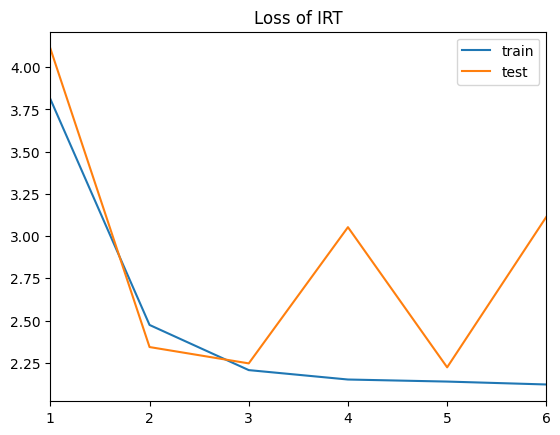

In [21]:
x = np.array(list(range(START_EPOCH, START_EPOCH+EPOCHS)))
plt.plot(x, np.array(train_loss_list),label='train')
plt.plot(x, np.array(test_loss_list),label='test')
plt.xlim([1, EPOCHS])
plt.title(f"Loss of IRT")
plt.legend(loc='upper right')
plt.show()

In [22]:
torch.save({
            'epoch': START_EPOCH+EPOCHS-1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'Checkpoint.pth')

# тестирование

In [23]:
print("predict_text target_text")

for ind, (x, _, y) in enumerate(test_dataloader):
    if ind > 10:
        break
    old_time = time.time()
    predict_text, target_text = evalSample(model, x, y)
    print(predict_text, target_text)

predict_text target_text
□mmmmm□□□□ 2FqSgZ□□□□
226m66□□□□ 21AS79□□□□
□Mmmmm□□□□ 431Upz□□□□
226666□□□□ 25GJDN□□□□
□mmLmL□□□□ 2J5Lxu□□□□
226666□□□□ 38eCFs□□□□
□MmmmL□□□□ 1zVvU2□□□□
□Mmmmm□□□□ 2GJR3m□□□□
226m66□□□□ 1ZAcce□□□□
□mmmmm□□□□ 18RcBM□□□□
2wmmmm□□□□ 2GzwKb□□□□


# очень плохие метрики